<a href="https://colab.research.google.com/github/kevinmcmanus/lto_utils/blob/master/lto_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LTO Utilities Library

The LTO Utilities library provides a set of useful functions for dealing with files output from the Little Thompson Observatory's radio telescope. These files, suffixed with '.lto' capture spectral information and the data processing pipeline produces them at approximately one-minute intervals throughout an observation.

For the purposes of this demo, a 24-hour drift scan observation is available in Google Cloud Storage.  Having the data in GCS complicates this demo somewhat in that the Google Colab virtual machine that is running this notebook needs to mount the GCS as a preliminary step.
The actual demonstration of obtaining and using the `lto_utils` library begins in the section entitled 'Clone the lto_utils' repo.

## Preliminaries

### References on Using Cloud Storage in Colab

These articles explain how to make Google Cloud Storage availabale within a Google Colab notebook, such as this one.

(https://medium.com/analytics-vidhya/how-to-access-files-from-google-cloud-storage-in-colab-notebooks-8edaf9e6c020)

(https://stackoverflow.com/questions/51715268/how-to-import-data-from-google-cloud-storage-to-google-colab)

(https://ostrokach.gitlab.io/post/google-colab-storage/)

### Authenticate and Mount GCS Bucket

In [ ]:
#from google.colab import auth

#auth.authenticate_user()

In [ ]:
#!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
#!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
#!apt -qq update
#!apt -qq install gcsfuse

In [ ]:
#Mount the drive
#!mkdir lto_data
#!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 lto_data lto_data

In [ ]:
#to mount your own google drive, do this:
#from google.colab import drive
#drive.mount('/content/drive')

## Clone the lto_utils Repo

In [ ]:
#!git clone https://github.com/kevinmcmanus/lto_utils

In [3]:
import lto_utils.lto_file as lto

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Read Single LTO File and Examine its Contents

In [297]:
#set the path to the object
#path = 'lto_data/2018_09_02/LTO-HI-2018-09-02-17-41-53.lto'
#path = r'C:\Users\Ellie\Documents\LTO Data\2020_08_10\LTO-SRGA-2020-08-10-03-23-30.lto'
#path = r'C:\Users\Ellie\Documents\LTO Data\2020_08_08\LTO-SRGA-2020-08-08-04-00-09.lto'
#path = r'C:\Users\Ellie\Documents\LTO Data\2020_08_11\LTO-SRGA-2020-08-11-04-09-41.lto'
path = r'C:\Users\Ellie\Documents\LTO Data\2020_08_10\LTO-SRGA-2020-08-10-03-42-05.lto'
#create an LTO_File object
lto_file = lto.LTO_File(path)


`lto_file` object contains two attributes: `SpectralHeader` and `SpectralData`. Both are large data structures. The `SpectralHeader` has several subsections which are:

In [298]:
lto_file.SpectralHeader.keys()

dict_keys(['Magic', 'Observatory', 'ObsLocation', 'BeamPosition', 'ObsTime', 'Spectrum', 'RadioCalibrations', 'ProgramControl', 'SpectralCharacteristics'])

 
The subsection `SpectralCharacteristics`  contains summary information of the file. 
 This subsection is particularly useful.

In [299]:
lto_file.SpectralHeader['SpectralCharacteristics']

{'avespecpwr': 1.5711914063203291e-21,
 'varspecpwr': 5.628148505357935e-45,
 'totalpwr': 1.971688095791382e-17,
 'numspecpwr': 12549,
 'numave': 26230,
 'numbad': 14,
 'aveindvpwr': 0.0018558488227427006,
 'varindvpwr': 2.780355390363809e-10,
 'peakpwr': 2.159561784222817e-21,
 'peakpwrfreq': 1420344655.25,
 'totalHIpwr': 1.2758551309050083e-18,
 'numHIpwr': 701,
 'avecrpwr': 1.5564674060608382e-21,
 'varcrpwr': 2.6875262475391685e-46,
 'numcrpwr': 11848,
 'avetsky': 112.73451232910156,
 'vartsky': 1.4098939634178782,
 'peaktsky': 156.41647768708123,
 'peaktskyfreq': 1420344655.25,
 'avefluxden': 23105.755327199975,
 'varfluxden': 1217160.0997105653,
 'peakfluxden': 31758.260641893266,
 'peakfluxfreq': 1420344655.25,
 'badspec': False,
 'processing': 'Raw FFT',
 'user': ''}

`SpectralData` is a  dictionary which essentially captures the spectrum and some other frequency-dependent measures.  Each dictionary element is a vector of length `nfft`.

In [300]:
lto_file.SpectralData.keys()

dict_keys(['dopfreq', 'rawavepwr', 'rawvarpwr', 'calavepwr', 'flatten', 'tsky', 'fluxden', 'badline', 'HIline'])

In [301]:
#type and length of the tsky member of the dictionary
n = len(lto_file.SpectralData['tsky'])
type(lto_file.SpectralData['tsky']), f'Length: {n}'

(numpy.ndarray, 'Length: 16385')

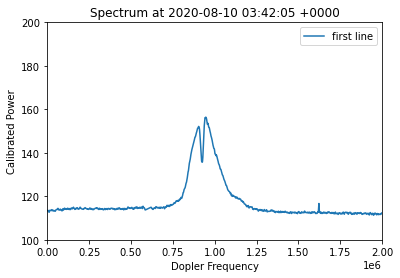

In [302]:
plt.plot(lto_file.SpectralData['dopfreq'], lto_file.SpectralData['tsky'], label = 'first line')
#plt.plot(lto_file.SpectralData['dopfreq'], lto_file.SpectralData['tsky']*1.1, label = 'second line')
plt.xlim(0, 2000000)
plt.ylim(100, 200)
plt.xlabel('Dopler Frequency')
plt.ylabel('Calibrated Power')
plt.legend()
zz=plt.title('Spectrum at '+lto_file.get_time().strftime('%Y-%m-%d %H:%M:%S %z'))

Sometimes it's easier to work with a `Pandas` dataframe. The `LTO_File` class provides a method to do so.

In [303]:
import pandas as pd
pd_df = lto_file.to_pandas()
print(len(pd_df))
pd_df.head()

16385


,ts,ra,dec,dopfreq,rawavepwr,rawvarpwr,calavepwr,flatten,tsky,fluxden,badline,HIline
0,2020-08-10 03:42:05+00:00,17.972969,-25.800467,-5000000.0,0.001856,2.780355e-10,1.571254e-21,0.000000,113.805519,23106.679688,True,False
1,2020-08-10 03:42:05+00:00,17.972969,-25.800467,-4999389.5,0.001856,2.780355e-10,1.571254e-21,0.000000,113.805519,23106.679688,True,False
2,2020-08-10 03:42:05+00:00,17.972969,-25.800467,-4998779.5,0.132688,1.772982e-02,2.297536e-20,44.365669,1664.099487,337873.000000,True,False
3,2020-08-10 03:42:05+00:00,17.972969,-25.800467,-4998169.0,0.073398,5.441707e-03,3.429081e-20,24.306440,2483.674072,504276.562500,True,False
4,2020-08-10 03:42:05+00:00,17.972969,-25.800467,-4997558.5,0.050191,2.509560e-03,3.850476e-20,16.588919,2788.889648,566246.500000,True,False


In [304]:
#testing locating variables of interest
#only want rows where HI line = true b/c no need to look for peaks elsewhere

print(pd_df.loc[pd_df['HIline'] == True])

                             ts         ra        dec       dopfreq  \
9426  2020-08-10 03:42:05+00:00  17.972969 -25.800467  7.531738e+05   
9427  2020-08-10 03:42:05+00:00  17.972969 -25.800467  7.537842e+05   
9428  2020-08-10 03:42:05+00:00  17.972969 -25.800467  7.543945e+05   
9429  2020-08-10 03:42:05+00:00  17.972969 -25.800467  7.550049e+05   
9430  2020-08-10 03:42:05+00:00  17.972969 -25.800467  7.556152e+05   
...                         ...        ...        ...           ...   
10122 2020-08-10 03:42:05+00:00  17.972969 -25.800467  1.177978e+06   
10123 2020-08-10 03:42:05+00:00  17.972969 -25.800467  1.178589e+06   
10124 2020-08-10 03:42:05+00:00  17.972969 -25.800467  1.179199e+06   
10125 2020-08-10 03:42:05+00:00  17.972969 -25.800467  1.179810e+06   
10849 2020-08-10 03:42:05+00:00  17.972969 -25.800467  1.621704e+06   

       rawavepwr  rawvarpwr     calavepwr   flatten        tsky       fluxden  \
9426    0.001902   0.000004  1.607286e-21  0.569538  116.415260  2

In [305]:
#smoothing slope to help get locate only true peaks

def smoothPascal(dataframe, centerIndex, column):
    pascalArray = np.array([1,6,15,20,15,6,1])
    #print(pascalArray)
    sum = 0
    for i in range(-3, 3):
        sum += (dataframe.at[(centerIndex + i), column]) * (pascalArray[3 + i])
        #print(sum)
        
    final = sum/64.0
   # if final < 0.2 and final > -0.2:
       # final = 0.0
        
    return final
        
    

In [306]:
#for index in range (9526, 10840):
def findPeaksValleys(df):
    
    peakList, valleyList = [], []
    
    for index in range(2, len(df)-3):

        if (df.loc[index, 'HIline']):
            
            #calculate slope for each point
            slope = (df['tsky'][index + 1] - df['tsky'][index] ) / (df['dopfreq'][index + 1] - df['dopfreq'][index])
            df.at[index, 'slope'] = slope * 10000
           # print(pd_df.loc[index, ['tsky', 'dopfreq', 'slope']])
        
            #apply smoothing algorithm to slopes
            smoothSlope = smoothPascal(df, index, 'slope')
            df.at[index, 'smooth_slope'] = smoothSlope
            #print(pd_df.loc[index, ['tsky', 'HIline', 'slope', 'smooth_slope']])

            #use slope to identify peaks/valleys 
            #lastSlopeDiff = (pd_df.at[index-2, 'smooth_slope'] - pd_df.at[index -1, 'smooth_slope'])
            #nextSlopeDiff = (pd_df.at[index+2, 'smooth_slope'] - pd_df.at[index +1, 'smooth_slope'])
            #nextSlope= pd_df.at[index+1, 'smooth_slope']

            #between neg slope increasing and pos slope decreasing and close to zero (one ish)
            #slopes before are decreasing in magnitude and after are increasing
            #magDecrease = abs(pd_df.at[index -2, 'smooth_slope']) > abs(pd_df.at[index -1, 'smooth_slope']) and abs(pd_df.at[index -1, 'smooth_slope']) > abs(pd_df.at[index, 'smooth_slope'])
            #magIncrease = abs(pd_df.at[index +2,'smooth_slope']) > abs(pd_df.at[index +1, 'smooth_slope']) and abs(pd_df.at[index +1, 'smooth_slope']) > abs(pd_df.at[index, 'smooth_slope'])

            #boolean for index is highest/lowest in neighborhood
            maxRange = 15
            isMax = max(df.loc[index - maxRange: index + maxRange, 'tsky']) == df.at[index, 'tsky']
            isMin = min(df.loc[index - maxRange: index + maxRange, 'tsky']) == df.at[index, 'tsky']

            df.at[index, 'isPeak'] = False
            df.at[index, 'isValley'] = False

            slopeThreshold = 0.3
            
            #if abs(smoothSlope) < slopeThreshold and lastSlopeDiff > 0 and nextSlopeDiff < 0 and isMax:
            #if abs(smoothSlope) < 1 and magDecrease == True and magIncrease == True and isMax :
            if isMax:
                df.at[index, 'isPeak'] = True
                #peaklist.extend(df.loc[index, ['ts', 'ra', 'dec', 'dopfreq', 'tsky']])
                peakList.append(index)

            #elif abs(smoothSlope) < slopeThreshold and lastSlopeDiff < 0 and nextSlopeDiff > 0 and isMin:
            #elif abs(smoothSlope) < 1 and magDecrease == True and magIncrease == True and isMin:
            if isMin:
                df.at[index, 'isValley'] = True
                valleyList.append(index)

            #print all rows where peak or valley == true
    print(df.loc[df['isPeak'] == True])
    print(df.loc[df['isValley'] == True])
            
    print(peakList)
    print(valleyList)
    return [peakList, valleyList]

In [307]:
def getAbsorbDepth(df):
    
    #returns lists with indexes of peaks and valleys in dataframe
    peaks, valleys = findPeaksValleys(df)

    #currently assumes 2 peaks and 1 valley *****************need to fix to deal with multi-peak spectra**************
    x1 = df.at[peaks[0], 'dopfreq']
    y1 = df.at[peaks[0], 'tsky']
    x = df.at[peaks[1], 'dopfreq']
    y = df.at[peaks[1], 'tsky']
    xValley = df.at[valleys[0], 'dopfreq']
    yValley = df.at[valleys[0], 'tsky']
    
    #m = ((peak1['tsky']- peak2['tsky'])/(peak1['dopfreq']- peak2['dopfreq']))
    #connect the peaks to get estimate of power at valley location
    m = (y - y1)/(x - x1)
    estimatedPower = (m * (xValley - x1)) + y1
    absorptionDepth = estimatedPower - yValley
    print(absorptionDepth)
    #if absoption Depth is negative, ??????????? set to 0???
        
    return {'ra': df.at[i, 'ra'], 'dec': df.at[i, 'dec'], 'abDep': absorptionDepth, 'dopfreq': df.at[i, 'dopfreq'] }

In [308]:
getAbsorbDepth(pd_df)

                             ts         ra        dec       dopfreq  \
9673  2020-08-10 03:42:05+00:00  17.972969 -25.800467  9.039307e+05   
9743  2020-08-10 03:42:05+00:00  17.972969 -25.800467  9.466552e+05   
10072 2020-08-10 03:42:05+00:00  17.972969 -25.800467  1.147461e+06   

       rawavepwr  rawvarpwr     calavepwr   flatten        tsky       fluxden  \
9673    0.002487   0.000006  2.100402e-21  0.566375  152.131516  30888.259766   
9743    0.002551   0.000006  2.159562e-21  0.567042  156.416473  31758.261719   
10072   0.001939   0.000004  1.643333e-21  0.570195  119.026131  24166.654297   

       badline  HIline     slope  smooth_slope isPeak isValley  
9673     False    True -0.114007           NaN   True    False  
9743     False    True -1.135956           NaN   True    False  
10072    False    True -0.688115           NaN   True    False  
                             ts         ra        dec    dopfreq  rawavepwr  \
9708  2020-08-10 03:42:05+00:00  17.972969 -25.8004

{'ra': 17.97296905517578,
 'dec': -25.800466537475586,
 'abDep': 18.591502462757347,
 'dopfreq': 910034.1875}

**TODO:** check out the ra and dec columns above

##Read All LTO Files in a Directory

`lto_utils` provides functionality to read all `.lto` in a directory. This can useful in summarizing an observing session, such as a drift scan.

**Caution:** the methods below will read **all** `.lto` files in the specified directory, so if there are files with duplicate content or `.lto` files from other observing sessions, such files will contaminate the results.

In [ ]:
# see the directories of observations:
!ls lto_data

These are early observations in the LTO Radio Telescope projects. As such, the quality of the data is suspect; however the observations will suffice for demonstration purposes.  Just don't base any science on these!!

The 2018_08_30 directory is a 24-hour drift scan, some 1440 files (one for each minute) in all.  The 2018_09_02 observation set is considerably smaller, so we'll demonstrate with it.  Doing so, however will compromise the plots that follow.

If you want to see a full 24-hour drift scan, set the scan date to `'2018_08_30'`.

In [ ]:
#obs_dir = '/Users/kevin/Documents/LTO Radiometry/HI_Detection/lto_cache'
#obs_dir = 'lto_data'
obs_dir = 'D:\LTO Data'
scan_date = '2020_08_13'

In [ ]:
#get all the spectral characteristics for the observation of 2018_09_02
# this can take a several minutes to run, espcially if the files are not local
obs_summary = lto.getSpectralCharacteristics(obs_dir+ '/' +scan_date)

In [ ]:
obs_summary.head()

In [ ]:
len(obs_summary)

In [ ]:
plt.plot(obs_summary.index, obs_summary.avetsky)
plt.title(f'Drift Scan Summary, Scan Date: {scan_date}')
plt.xlabel('Time (UT)')
plt.xticks(rotation=90)
plt.ylabel('Average Sky Temp (K)')

In [ ]:
#it's a drift scan so plot by right ascension
plt.scatter(obs_summary.ra, obs_summary.avetsky, s=9)
plt.title(f'Drift Scan Summary, Scan Date: {scan_date}')
plt.xlabel('Right Ascension (deg)')
plt.xticks(rotation=90)
plt.ylabel('Average Sky Temp (K)')
plt.grid()
plt.gca().invert_xaxis()

In [ ]:
#this takes quite a bit of time on goolge, not so much when data is local

#get all the spectral data from the drift scan
#spectra = lto.getDriftScan(obs_dir+ '/' +scan_date)

In [ ]:
spectra.head()

Yeilds a rather large data frame:

In [ ]:
len(spectra)

## Construct a Spectrogram

The `spectra` data frame from above can be unweildy with 23 million rows, so the `getDriftScan` method provides a `dfclip` parameter to eliminate data at the far ends of the spectrum. If we clip the spectrum, the production of the spectrogram proceeds much faster, because the resulting data set is so much smaller.

In [ ]:
#clip to -300 kHz to 300 kHz
spectra = lto.getDriftScan(obs_dir+ '/' +scan_date, dfclip=(0, 0.2e7))
len(spectra)

In [ ]:
#make the temperature array dopfreq x time

#sort the spectra data frame
spectra.sort_values(['dopfreq', 'ts'], inplace=True)

#get the y axis (dopler freq) values:
dopfreqs = spectra.dopfreq.unique()

# next, get the x-axis which is the time of the observations;
obs_times = spectra.ts.unique()

#make the temperature array
skytemp = np.array(spectra.tsky).reshape(len(dopfreqs), len(obs_times))

skytemp.shape

In [ ]:
#helper routine to beautify the time formating:
import matplotlib.dates as mdates
fmt = mdates.DateFormatter('%H:%M')

#for the normalizer:
import matplotlib.colors as colors



In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()

pcm = ax.pcolormesh(obs_times, dopfreqs, skytemp,cmap='gnuplot',
                norm=colors.LogNorm())
                   #norm=colors.PowerNorm(gamma=1./2.))
fig.colorbar(pcm, label='Sky Temp (K)')

plt.xlabel('Time (UT)')
plt.gca().xaxis.set_major_formatter(fmt)
plt.xticks(rotation=90)
plt.ylabel('Dopler Shift (kHz)')
plt.title(f'LTO Driftscan of {scan_date}',fontdict={'fontsize':16, 'fontweight':'bold'})
plt.grid()